# Test Script - Gaussian Processes Regressor

## Loading Libraries

In [1]:
import os
import torch
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

import pickle
import random
import time

# Importing Scikit-Learn Models
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import ConstantKernel, DotProduct, ExpSineSquared, Matern, RBF
from sklearn.decomposition import TruncatedSVD

# Importing Bayesian Optimizer and Acquisition Functions
from modAL.models import BayesianOptimizer
from modAL.acquisition import max_EI, max_PI, max_UCB

# Importing Custom Acquisiton Functions and Decay Functions
import utils
from utils import StepWiseDecay

## Parameters

Parameterised Cell Block

In [2]:
# parameters
fingerprint = 'morgan'
model = 'GPR'
file_name = "complete_file_morgan.feather"
config_file_name = 'GPR.json'
use_subset = True
use_unified_file = True
use_decomposition = False
assay_limit = 300

## Loading Datasets

In [3]:
random.seed(42)
file_path = '/data_temp/default_{}/'.format(fingerprint)

try:
    if use_unified_file == True:
        try:
            df = pd.read_feather("../data" + file_path + file_name)
        except:
            df = pd.read_parquet("../data" + file_path + file_name)
        df_nan = pd.read_parquet("../data" + file_path + "assay_id/assay_id_null_file.parquet")
        df_assays = pd.read_parquet("../data" + file_path + "assay_id/assay_id_file.parquet")

    elif use_unified_file == False:
        df_fingerprint = pd.read_parquet("../" + file_path + "/fingerprint/{}_fingerprint_file.parquet".format(fingerprint))
        df = pd.read_parquet("../" + file_path + "/preprocessed/preprocessed_file.parquet")
        df_nan = pd.read_parquet("../" + file_path + "/assay_id/assay_id_null_file.parquet")
        df_assays = pd.read_parquet("../" + file_path + "/assay_id/assay_id_file.parquet")
    else:
        print("Incorrect value for 'use_unified_file' parameter passed. Please recheck.")
        pass
except FileNotFoundError as e:
    print("Data File not found: {}".format(e))
except OSError as e:
    print("Possible OS Error: {}".format(e))

In [13]:
os.getcwd()

'c:\\Users\\Rahil\\Documents\\Github\\drug-discovery-al\\scripts'

Identifying noisy assays

In [4]:
df_nan.loc[df_nan['squared_pearson_trn'].isnull()]

,assay_id,squared_pearson_trn,squared_pearson_tst,assay_length_trn,assay_length_tst,assay_length_total
1,303216,NaN,NaN,45,15,60
2,303260,NaN,NaN,45,15,60
4,737235,NaN,NaN,45,15,60


Removing Noisy Assays

In [5]:
# df = df.drop(nan_assays)
for i in df_nan.loc[df_nan['squared_pearson_trn'].isnull()]['assay_id']:
    df = df.drop(labels = df.loc[df['assay_id']==i].index)
df.loc[df['assay_id']==303216].head()
print('x-----x-----x-----x')
df.loc[df['assay_id']==303260].head()
print('x-----x-----x-----x')
df.loc[df['assay_id']==737235].head()
print('x-----x-----x-----x')

x-----x-----x-----x
x-----x-----x-----x
x-----x-----x-----x


Loading Config Files

In [6]:
# Loading JSON config file
try:
    with open('../config/' + config_file_name) as f:
        params_config = json.load(f)
        print('JSON config file for {} successfully loaded'.format(model))
except FileNotFoundError:
    print('Config file for model {} is missing.Resorting to default params'.format(model))
    with open('../config/{}_default.json'.format(model)) as f:
        params_config = json.load(f)

try:
    with open('../config/decay_values.json') as f:
        decay_list = json.load(f)
        decay_list = decay_list["decay values"]
except:
    decay_list = [1.0,0.75,0.5,0.25,0.125,0.1,0.05]
    print('Config file for decay values is missing. Resorting to default values: {}'.format(decay_list))

if os.path.isdir('../models/{0}_{1}/'.format(model,fingerprint)) == False:
    os.mkdir('../models/{0}_{1}/'.format(model,fingerprint))

if os.path.isdir('../data/data_results/{0}_{1}/'.format(model,fingerprint)) == False:
    os.mkdir('../data/data_results/{0}_{1}/'.format(model,fingerprint))

if os.path.isdir('../data/data_results/{0}_{1}/plots'.format(model,fingerprint)) == False:
    os.mkdir('../data/data_results/{0}_{1}/plots'.format(model,fingerprint))

# Creating List of Classifiers
clfs = []
acquisition_list = []
clf_list = []
count = 0
clf_list_names = []

for kernel in params_config["kernel"]:
    if kernel == "Matern()":
        clf_type = GPR(kernel=Matern(length_scale=params_config["matern_params"]["length_scale"],
                                length_scale_bounds=(params_config["matern_params"]["length_scale_bounds"]["low"],params_config["matern_params"]["length_scale_bounds"]["high"]),
                                nu=params_config["matern_params"]["nu"]),
                    alpha=(params_config["alpha"]))
    elif kernel == "RBF()":
        clf_type = GPR(kernel=RBF(length_scale=params_config["rbf_params"]["length_scale"],
                                length_scale_bounds=(params_config["rbf_params"]["length_scale_bounds"]["low"],params_config["rbf_params"]["length_scale_bounds"]["high"])),
                    alpha=(params_config["alpha"]))
    else:
        clf_type = GPR(alpha=(params_config["alpha"]))
    clf = {
        "type" : clf_type,
        "name" : kernel
    }
    clfs.append(clf)

for function in params_config["acquisition"]:
    if function=="max_EI":
        acquisition_type = max_EI
    elif function=="max_PI":
        acquisition_type = max_PI
    elif function=="max_UCB":
        acquisition_type = max_UCB
    elif function=="random":
        acquisition_type = utils.random_sampling
    elif function=="equivalent":
        acquisition_type = utils.equivalent_sampling
    elif function=="margin_entropy":
        acquisition_type = utils.margin_entropy_sampling
    elif function=="uncertainty_margin":
        acquisition_type = utils.uncertainty_margin_sampling
    elif function=="product_sampling":
        acquisition_type = utils.product_sampling
    else:
        acquisition_type = max_EI
    acquisition = {
        "type" : acquisition_type,
        "name": function
    }
    acquisition_list.append(acquisition)

for model_selected in clfs:
    for ac_func in acquisition_list:
        clf = {
            "model" :model_selected["type"],
            "model_name" : model_selected["name"],
            "acquisition_function" :ac_func["type"],
            "acquisition_function_name" : ac_func["name"]
        }
        clf_list.append(clf)
        clf_list_names.append("model_{}_{}".format(clf["model_name"], clf["acquisition_function_name"]))
        count+=1

clf_list_names = ['assay_id','subset_size_trn','total_length'] + clf_list_names

num_iterations=params_config["iterations"]

JSON config file for GPR successfully loaded


Creating the dynamic Result Data Matrix to store the results

In [7]:
pearson_trn = [[0 for i in range(len(clf_list)+3)] for j in range(len(df["assay_id"].unique()+1))]
pearson_tst = [[0 for i in range(len(clf_list)+3)] for j in range(len(df["assay_id"].unique()+1))]

pearson_values_graph = [[0 for i in range(len(acquisition_list))] for j in range(num_iterations)]


Suppresing warnings

In [8]:
import warnings
warnings.simplefilter('ignore')

## Training Cycle

In [9]:
list_subset_sizes = []
list_total_sizes = []
row = 0
column = 0
pvg_column = 0
pvg_row = 0

# Assay for which graphs have to be generated
# flag_first_assay = 688239
# flag_first_assay = 517
flag_first_assay = 70695

first_start = time.time()

# Intialising the Decay Function

try:
    decay_tracker = utils.StepWiseDecay(decay_list)
    count = 0

    for assay_id in df['assay_id'].unique():
        if assay_id == np.int64(flag_first_assay):
            print('Reached selected assay at time = {}'.format(time.time() - first_start))

        # Isolating the training and testing samples for the specfic assay
        df_current = df.loc[df['assay_id']==assay_id]
        df_train = df_current.loc[df['Clustering']=='TRN']
        df_tst = df_current.loc[df['Clustering']=='TST']
        column=0
        pvg_column = 0


        # Uncomment this snippet to generate model only for a single assay as specified by 'flag_first_assay'
        if assay_id != np.int64(flag_first_assay):
            continue

        start = time.time()

        # Initialising the length of the required subset as dictated by the Decay Function
        subset_size = int(decay_tracker.calculate(df_train.shape[0])*df_train.shape[0])
        list_subset_sizes.append(subset_size)
        list_total_sizes.append(df_train.shape[0])
        if assay_id == np.int64(flag_first_assay):
            print("\nThe current assay id is {} and initialisation size is {}\n".format(assay_id, subset_size))
        pearson_trn[row][column] = assay_id
        pearson_tst[row][column] = assay_id
        column+=1
        
        # Whether to use subset of the entire sample space as the query space
        if use_subset == True:
            X = np.array(df_train.iloc[:,10:])[:subset_size]
            y = np.array(df_train.iloc[:,3])[:subset_size]
        else:
            X = np.array(df_train.iloc[:,10:])
            y = np.array(df_train.iloc[:,3])

        # Perform decomposition if 'use_decomposition' parameter is set to True
        if use_decomposition == True:
            transformer = TruncatedSVD(n_components=128, random_state=42).fit(X)
            X = transformer.transform(X)
            with open('../models/{0}_{1}/transformer_{2}.pickle'.format(model,fingerprint,assay_id),'wb') as f:
                    pickle.dump(transformer,f)
        
        # Select initial values to teach the Optimzer object
        train_idx = np.random.choice(range(X.shape[0]), size=int(X.shape[0]*0.1), replace=False)
        
        x_initial = X[train_idx]
        y_initial = y[train_idx]

        X = np.delete(X,train_idx, axis=0)
        y = np.delete(y,train_idx)


        pearson_trn[row][column] = subset_size
        pearson_tst[row][column] = subset_size
        column+=1

        pearson_trn[row][column] = df_train.shape[0]
        pearson_tst[row][column] = df_tst.shape[0]
        column+=1

        
        if use_unified_file==True:

            # Training cycle for each model-acquistion function pairs
            for gpr_model in clf_list:
                X_train = X
                y_train = y
                if assay_id==np.int64(flag_first_assay):
                    print("Data is for model {} with acc_func {}".format(gpr_model["model_name"], gpr_model["acquisition_function_name"]))
                clf = gpr_model["model"]

                # Creating the BayesianOptimizer object with the initial values
                learner = BayesianOptimizer(
                    estimator=clf,
                    query_strategy=gpr_model["acquisition_function"],
                    X_training=x_initial, y_training=y_initial
                )

                pvg_row=0
                for n_query in range(num_iterations):
                    if assay_id==np.int64(flag_first_assay):

                        if use_decomposition == True:
                            with open('../models/{0}_{1}/transformer_{2}.pickle'.format(model,fingerprint,assay_id),'rb') as f:
                                transformer = pickle.load(f)
                            predictions_first_assay = learner.predict(transformer.transform(np.array(df_train.iloc[:,10:])))
                        else:
                            predictions_first_assay = learner.predict(np.array(df_train.iloc[:,10:]))
                        pearson_values_graph[pvg_row][pvg_column] = round(np.corrcoef(np.array(df_train.iloc[:,3]), predictions_first_assay)[0,1]**2,5)

                        pvg_row+=1

                        # Querying samples from the the query space
                        try:
                            query_idx,query_inst = learner.query(X_train, n_instances=20)
                        except:
                            print("Encountered a case where the number of instances is lower than utility")
                        
                        # Teaching the BayesianOptimizer Object
                        learner.teach(X=query_inst,y=y[query_idx])

                # Saving the generated model
                with open('../models/{0}_{1}/{2}_{3}_{4}.pickle'.format(model,fingerprint,gpr_model["model_name"],gpr_model["acquisition_function_name"],assay_id),'wb') as f:
                    pickle.dump(learner,f)

                # Loading the pre-generated model
                with open('../models/{0}_{1}/{2}_{3}_{4}.pickle'.format(model,fingerprint,gpr_model["model_name"],gpr_model["acquisition_function_name"],assay_id),'rb') as f:
                    learner = pickle.load(f)

                # Predict model performance on the training samples
                if use_decomposition == True:
                    with open('../models/{0}_{1}/transformer_{2}.pickle'.format(model,fingerprint,assay_id),'rb') as f:
                        transformer = pickle.load(f)    
                    predictions = learner.predict(transformer.transform(np.array(df_train.iloc[:,10:])))
                else:
                    predictions = learner.predict(np.array(df_train.iloc[:,10:]))
                result_trn = round(np.corrcoef(np.array(df_train.iloc[:,3]), predictions)[0,1]**2,5)

                # Predict model performance on the testing samples
                if use_decomposition == True:
                    with open('../models/{0}_{1}/transformer_{2}.pickle'.format(model,fingerprint,assay_id),'rb') as f:
                        transformer = pickle.load(f)     
                    predictions = learner.predict(transformer.transform(np.array(df_tst.iloc[:,10:])))
                else:
                    predictions = learner.predict(np.array(df_tst.iloc[:,10:]))
                result_tst = round(np.corrcoef(np.array(df_tst.iloc[:,3]), predictions)[0,1]**2,5)

                # Saving the model predictions in the Result Data Matrix
                pearson_trn[row][column] = result_trn
                pearson_tst[row][column] = result_tst
                
                column+=1
                pvg_column+=1
        else:
            print("Feature is in the works.")   
        row+=1
        count+=1
        print("Parsed {} assays".format(count))
        if count >= assay_limit:
                break
    print('Reached selected assay at time = {}'.format(time.time() - start))
except NameError:
    print('Key Error')

Reached selected assay at time = 53.89483165740967

The current assay id is 70695 and initialisation size is 50

Data is for model Matern() with acc_func max_UCB
Data is for model Matern() with acc_func max_PI
Data is for model Matern() with acc_func max_EI
Parsed 1 assays
Reached selected assay at time = 852.6934101581573


Displaying the time taken for model creation

In [10]:
print('Reached selected assay at time = {}'.format(time.time() - start))

Reached selected assay at time = 852.8583750724792


Results of the selected assay

In [11]:
pearson_values_graph

[[0.50104, 0.50104, 0.50104],
 [0.60038, 0.60122, 0.60122],
 [0.5967, 0.78628, 0.78628],
 [0.59902, 0.81095, 0.81095],
 [0.59901, 0.81095, 0.81095],
 [0.59901, 0.81095, 0.81095],
 [0.59901, 0.81095, 0.81095],
 [0.59901, 0.81095, 0.81095],
 [0.59901, 0.81095, 0.81095],
 [0.59901, 0.81095, 0.81095],
 [0.59901, 0.81095, 0.81095],
 [0.59901, 0.81095, 0.81095],
 [0.59901, 0.81095, 0.81095],
 [0.59901, 0.81095, 0.81095],
 [0.59901, 0.81095, 0.81095],
 [0.59901, 0.81095, 0.81095],
 [0.59901, 0.81095, 0.81095],
 [0.59901, 0.81095, 0.81095],
 [0.59901, 0.81095, 0.81095],
 [0.59901, 0.81095, 0.81095],
 [0.59901, 0.81095, 0.81095],
 [0.59901, 0.81095, 0.81095],
 [0.59901, 0.81095, 0.81095],
 [0.59901, 0.81095, 0.81095],
 [0.59901, 0.81095, 0.81095]]

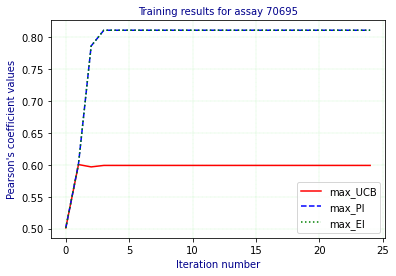

In [12]:
pd.DataFrame(pearson_trn, columns=clf_list_names).to_csv('../data/data_results/{0}_{1}/pearsons_training_set_{2}.csv'.format(model,fingerprint,num_iterations),index=False)
pd.DataFrame(pearson_tst, columns=clf_list_names).to_csv('../data/data_results/{0}_{1}/pearsons_test_set_{2}.csv'.format(model,fingerprint,num_iterations),index=False)

pearson_values_graph = pd.DataFrame(pearson_values_graph, columns=params_config["acquisition"])
pearson_values_graph.to_csv('../data/data_results/{0}_{1}/squared_pearson_{2}.csv'.format(model,fingerprint,flag_first_assay),index=False)

colours = ['-r','--b',':g','^y','-.k','.c','om','xk']
colour_count = 0
font_custom = {
    "family" : "sans-serif",
    "color" : "darkblue",
    "size" : "10"
    }

plt.title("Training results for assay {}".format(flag_first_assay), fontdict=font_custom, loc='center')
plt.xlabel("Iteration number", fontdict=font_custom)
plt.ylabel("Pearson's coefficient values", fontdict=font_custom)


for (column_name,column_contents) in pearson_values_graph.iteritems():
    plt.plot([x for x in range(len(column_contents))],column_contents, colours[colour_count], label='{}'.format(column_name))
    colour_count +=1
plt.grid(color = 'lightgreen', linestyle = '--', linewidth =0.25)
plt.legend()
plt.savefig('../data/data_results/{0}_{1}/plots/training_cycles_{2}.jpg'.format(model,fingerprint,flag_first_assay),
                format='jpg',
               )
plt.show()